In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
torch.random.seed = 42

import numpy as np

import random
import gc
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Configs

In [2]:
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
n_epochs = 5
log_interval = 10

In [3]:
data_dir = os.path.abspath(os.path.relpath('../data'))
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

# Load dataset

In [4]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(32),
                                    torchvision.transforms.ToTensor(), 
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])
                                )

mnist_testset = datasets.MNIST(root='../data', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(32),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                                    ])
                              )

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size_train, True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size_test, True)

In [6]:
torch.utils.data.Subset(train_loader, [1, 2, 3]).dataset

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

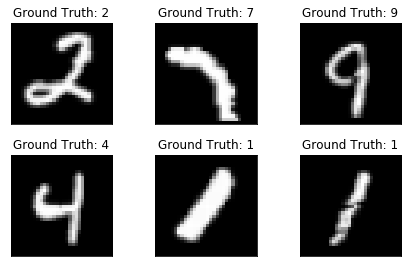

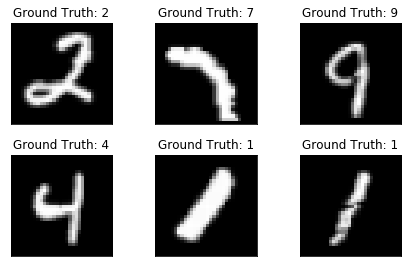

In [8]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# Helper functions

In [9]:
def train(epoch, net, optimizer, train_loader, v=1, track=0):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (v > 0) and (batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        if track > 0:
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
#         torch.save(network.state_dict(), 'model.pth')
#         torch.save(optimizer.state_dict(), 'optimizer.pth')

In [10]:
def test(net, optimizer, test_loader, v=1, track=0):
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    if track > 0:
        test_losses.append(test_loss)
    if v>0:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct.item()/len(test_loader.dataset)

In [11]:
def kfold(k, N, epochs, model, optimizer, state_dict, train_loader):
    loss_avg = 0
    acc_avg = 0
    for i in range(k):
        model.load_state_dict(state_dict)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        epoch = 0
        count = 0
        min_error = 100
        max_acc = 1
        train_mask = []
        val_mask = []
        for i in range(60000):
            if i%k == 0:
                val_mask.append(i)
            else:
                train_mask.append(i)
        X_train = torch.utils.data.Subset(train_loader.dataset, train_mask)
        X_val = torch.utils.data.Subset(train_loader.dataset, val_mask)
        X_train_l = torch.utils.data.DataLoader(X_train, batch_size_train, True)
        X_val_l = torch.utils.data.DataLoader(X_val, batch_size_test, True)
        while (epoch < epochs and count < 2):
            train(epoch, model, optimizer, X_train_l, 0)
            test_loss, test_acc = test(model, optimizer, X_val_l, 0)
            epoch += 1
            if test_loss >= min_error:
                count += 1
            else:
                min_error = test_loss
                max_acc = test_acc
            print('{:.4f} - '.format(test_loss), end='')
        loss_avg += min_error
        acc_avg += max_acc
        print('{:.4f} ({:4.2f}%) |'.format(min_error, 100*max_acc), end='')
    print('>')
    return loss_avg/k, acc_avg/k

# Architectures

## MLP

In [12]:
class MLP(nn.Module):
    """MLP with 3 ReLU hidden layers and 1 softmax output layer"""
    
    def __init__(self, H, D):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(D)
        
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.dropout(x)
        x = self.relu(self.fc1(x)) # H
        x = self.dropout(x)
        x = self.relu(self.fc2(x)) # H
        x = self.dropout(x)
        x = self.relu(self.fc3(x)) # H
        x = self.dropout(x)
        x = F.log_softmax(self.fc4(x)) # 10
        return x

## CNN

In [13]:
class CNN(nn.Module):
    """CNN inspired in LeNet 5"""
    def __init__(self, D):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(D)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 6 @ 14x14
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) # 16 @ 5x5
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) # 120
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # 84
        x = self.dropout(x)
        x = self.fc3(x)         # 10
        return F.log_softmax(x)

# MLP

In [14]:
models = []
for H in [30, 60, 100, 300, 600]:
    for D in [0, 0.3, 0.5]:
        model = MLP(H, D)
        copy = MLP(H, D)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print('D =', D, 'H =', H)
        loss, acc = kfold(5, 60000, 5, model, optimizer, copy.state_dict(), train_loader)
        print()
        models.append((H, D, loss, acc)) 

D = 0 H = 30


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0.2308 - 0.2318 - 0.2175 - 0.2414 - 0.2175 (94.27%) |0.2422 - 0.2103 - 0.1895 - 0.1962 - 0.1865 - 0.1865 (95.38%) |0.2392 - 0.2088 - 0.2204 - 0.2332 - 0.2088 (94.49%) |0.2288 - 0.2575 - 0.2144 - 0.2289 - 0.2144 (94.08%) |0.2794 - 0.2511 - 0.2335 - 0.2414 - 0.2140 - 0.2140 (94.17%) |>

D = 0.3 H = 30
0.4507 - 0.5482 - 0.4620 - 0.4507 (89.08%) |0.5890 - 0.5652 - 0.6100 - 0.5295 - 0.5295 - 0.5295 (86.41%) |0.5002 - 0.4439 - 0.4387 - 0.4703 - 0.4242 - 0.4242 (88.58%) |0.4847 - 0.4177 - 0.4614 - 0.4789 - 0.4177 (89.13%) |0.5285 - 0.4605 - 0.4756 - 0.4237 - 0.4753 - 0.4237 (89.09%) |>

D = 0.5 H = 30
0.9694 - 0.9950 - 0.9480 - 0.9419 - 1.0321 - 0.9419 (66.62%) |0.9800 - 0.9969 - 1.0336 - 0.9800 (63.55%) |1.0726 - 1.0392 - 1.0655 - 1.0049 - 0.9938 - 0.9938 (63.34%) |0.9937 - 0.9270 - 0.9670 - 0.9977 - 0.9270 (76.28%) |0.9747 - 0.9526 - 0.9902 - 0.9919 - 0.9526 (64.10%) |>

D = 0 H = 60
0.2430 - 0.2347 - 0.2158 - 0.1886 - 0.2557 - 0.1886 (94.73%) |0.2695 - 0.2017 - 0.1921 - 0.1893 - 0.1816 - 0

In [15]:
models

[(30, 0, 0.20826131896972658, 0.9448000000000001),
 (30, 0.3, 0.4491659454345703, 0.8845833333333333),
 (30, 0.5, 0.9590570495605469, 0.6677833333333333),
 (60, 0, 0.18633534393310547, 0.9496166666666668),
 (60, 0.3, 0.3367136370340983, 0.9179),
 (60, 0.5, 0.7203235127766927, 0.7906333333333333),
 (100, 0, 0.18133897959391276, 0.9543166666666666),
 (100, 0.3, 0.33632603861490884, 0.9142833333333333),
 (100, 0.5, 0.6630641774495443, 0.8253166666666667),
 (300, 0, 0.19735110880533852, 0.9496166666666668),
 (300, 0.3, 0.46191029052734384, 0.8838666666666667),
 (300, 0.5, 1.0953088205973307, 0.6634166666666667),
 (600, 0, 0.22767286071777343, 0.9414333333333333),
 (600, 0.3, 0.5983422429402669, 0.85625),
 (600, 0.5, 1.4112142720540364, 0.5096999999999999)]

In [16]:
mlp = MLP(100, 0)
n_epochs = 10
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [17]:
test(mlp, optimizer, test_loader, v=1, track=1)
for epoch in range(1, n_epochs + 1):
    train(epoch, mlp, optimizer, train_loader, v=1, track=1)
    test(mlp, optimizer, test_loader, v=1, track=1)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3042, Accuracy: 1406/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307030
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.924399
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.282054
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.510988
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.764993
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.372549
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.378435
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.377724
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.213418
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.274366
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.532825
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.458595
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.504578
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.224199
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.944259
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.353598
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.360291
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.462948
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.230323
Train Epoch: 1 [12160

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.110776
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.235862
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.059977
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.288705
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.206228
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.290630
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.265775
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.051566
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.130839
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.140411
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.265354
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.179770
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.154204
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.128517
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.449701
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.166913
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.259583
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.368571
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.175580
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.144339


Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.310144
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.300209
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.258472
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.125897
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.053928
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.211521
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.242016
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.099572
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.050352
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.451440
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.190274
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.232213
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.286945
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.060418
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.165645
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.055601
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.158022
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.117484
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.040450
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.224532


Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.108238
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.218938
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.103957
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.148074
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.157807
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.214964
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.330102
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.163125
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.206087
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.296395
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.091639
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.084639
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.061344
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.426099
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.256863
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.095918
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.160151
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.429646
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.052416
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.089613


Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.131027
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.086190

Test set: Avg. loss: 0.1975, Accuracy: 9599/10000 (95%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.149970
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.149461
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.592094
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.314099
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.048940
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.165650
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.133192
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.046674
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.141386
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.229353
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.261987
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.064088
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.137755
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.038994
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.242315
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.136328
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.154354
Train Epoch: 8 [10880

Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.098644
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.024024
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.142285
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.179364
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.039615
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.242682
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.142334
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.182864
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.061234
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.187236
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.111686
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.302784
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.031021
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.161739
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.210525
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.087001
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.133744
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.152033
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.164097
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.161898


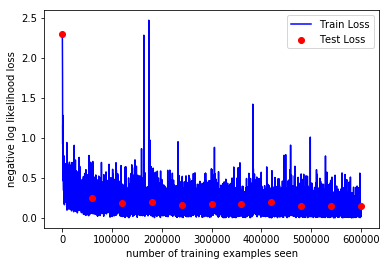

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.savefig(os.path.join(image_dir, 'mlp.png'), bbox_inches='tight')
plt.show()

# CNN

In [19]:
models_cnn = []
for D in [0, 0.3, 0.5]:
    model = CNN(D)
    copy = CNN(D)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print('D =', D)
    loss, acc = kfold(5, 60000, 5, model, optimizer, copy.state_dict(), train_loader)
    print()
    models_cnn.append((D, loss, acc)) 

D = 0


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.1095 - 0.1053 - 0.1283 - 0.1250 - 0.1053 (97.51%) |0.1338 - 0.2235 - 0.0988 - 0.1172 - 0.0988 (97.62%) |0.0963 - 0.1100 - 0.1522 - 0.0963 (97.52%) |0.1404 - 0.1091 - 0.1082 - 0.1122 - 0.0948 - 0.0948 (97.89%) |0.1164 - 0.1165 - 0.1295 - 0.1164 (96.94%) |>

D = 0.3
0.1127 - 0.1261 - 0.1027 - 0.1070 - 0.1027 (97.28%) |0.0922 - 0.1373 - 0.1931 - 0.0922 (97.71%) |0.1266 - 0.1011 - 0.1109 - 0.1069 - 0.1011 (97.59%) |0.0910 - 0.1051 - 0.1065 - 0.0910 (97.50%) |0.0858 - 0.1273 - 0.0937 - 0.0858 (97.68%) |>

D = 0.5
0.1474 - 0.1126 - 0.1112 - 0.1400 - 0.1319 - 0.1112 (97.11%) |0.1371 - 0.1112 - 0.1205 - 0.1190 - 0.1112 (97.09%) |0.1769 - 0.1087 - 0.1467 - 0.1272 - 0.1087 (97.29%) |0.1067 - 0.1406 - 0.1207 - 0.1067 (96.93%) |0.1331 - 0.1240 - 0.1366 - 0.1127 - 0.1278 - 0.1127 (96.91%) |>



In [20]:
models_cnn

[(0, 0.10235103963216145, 0.9749666666666666),
 (0.3, 0.09454252503712972, 0.9755333333333333),
 (0.5, 0.11012842330932618, 0.9706666666666667)]

In [21]:
train_losses_mlp = train_losses[:]
test_losses_mlp = test_losses[:]

In [22]:
cnn = CNN(0.3)
n_epochs = 10
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [23]:
test(cnn, optimizer, test_loader, v=1, track=1)
for epoch in range(1, n_epochs + 1):
    train(epoch, cnn, optimizer, train_loader, v=1, track=1)
    test(cnn, optimizer, test_loader, v=1, track=1)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3050, Accuracy: 728/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309298
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.507382
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.963328
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.917382
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.507429
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.409001
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.478804
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.453853
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.607625
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.517418
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.508507
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.344937
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.321559
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.417129
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.455993
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.197648
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.261090
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.335606
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.238577
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.129452
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.139139
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.100194
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.185310
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.268291
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.057207
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.139986
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.243371
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.154554
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.230518
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.111701
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.084485
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.587211
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.068148
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.080654
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.115495
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.159645
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.430429
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.177800
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.576108


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.186203
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.077703
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.247735
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.260070
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.079429
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.140305
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.090095
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.129303
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.136016
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.247916
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.364556
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.171950
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.382126
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.103872
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.069354
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.072888
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.091948
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.239351
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.140075
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.237931


Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.178484
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.285195
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.191856
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.359333
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.485988
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.233323
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.134017
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.392654
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.559463
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.043235
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.129840
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.277772
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.493144
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.123145
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.076790
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.164229
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.268344
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.366715
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.213547
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.163599


Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.319616
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.058091
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.245557
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.114331
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.048924

Test set: Avg. loss: 0.0864, Accuracy: 9771/10000 (97%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.146981
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.099988
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.062771
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.094793
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.105352
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.038899
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.145757
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.037104
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.118679
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.090020
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.124413
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.118939
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.073299
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.092409
Train Epoch: 8 [896

Train Epoch: 9 [40960/60000 (68%)]	Loss: 0.143477
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.169472
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.386192
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.116610
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.535306
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.241410
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.290276
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.197696
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.375039
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.522234
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.068815
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.270907
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.135637
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.156154
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.090123
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.194963
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.227019
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.281624
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.236836
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.053478


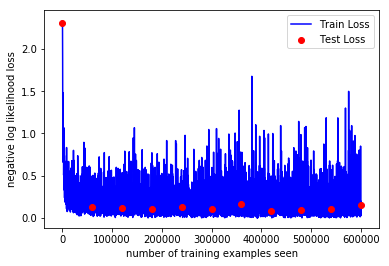

In [24]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.savefig(os.path.join(image_dir, 'cnn.png'), bbox_inches='tight')
plt.show()

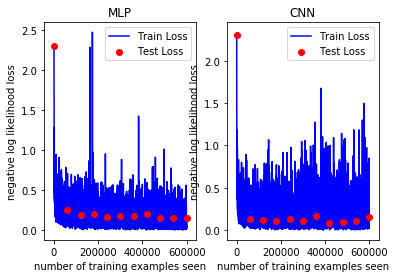

In [25]:
fig = plt.figure()

plt.subplot(1,2,1)
plt.plot(train_counter, train_losses_mlp, color='blue', zorder=1)
plt.scatter(test_counter, test_losses_mlp, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.title('MLP')

plt.subplot(1,2,2)
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.title('CNN')

plt.savefig(os.path.join(image_dir, 'learning_curves.png'), bbox_inches='tight')